# Can ResNet-50 v1.5, fine-tuned with chest X-rays, achieve state-of-the-art performance in detecting COVID-19 pneumonia from chest X-rays, while requiring fewer training resources compared to other deep learning models?

In [ ]:
!pip install torch
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.0 MB/s eta 0:00:00


# Import libraries


In [ ]:
import tensorflow as tf
from transformers import TFTrainer, TFTrainingArguments, AutoModelForImageClassification
import numpy as np
import pathlib
import zipfile
import os
import PIL
import matplotlib.pyplot as plt


In [ ]:
IMAGE_SHAPE = (224,224) # set image size as s static value



# Inseart database

In [ ]:
data_path = '/content/data_x.zip'
data_dir = tf.keras.utils.get_file('121312412424', origin = 'file://' + data_path, untar = True)
data_dir = pathlib.Path(data_dir)

84491291/84491291 [==============================] - 0s 0us/step


In [ ]:
print(data_dir)

/root/.keras/datasets/121312412424


In [ ]:
for item in data_dir.glob('*'):
    print(item)

In [ ]:
extracted_dir = pathlib.Path('/content/extracted_data')
extracted_dir.mkdir(exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile('/content/data_x.zip', 'r') as zip_ref:
    zip_ref.extractall(extracted_dir) # extracting zip file

# Now, update data_dir to point to the extracted directory
data_dir = extracted_dir

In [ ]:
archive_dir = data_dir
print(archive_dir.exists())  # Check if 'archive' directory exists
print(list(archive_dir.glob('*')))

True
[PosixPath('/content/extracted_data/Normal'), PosixPath('/content/extracted_data/COVID')]


# split images by their folder (COVID, Normal)

/content/extracted_data/Normal/Normal-658.png
1200


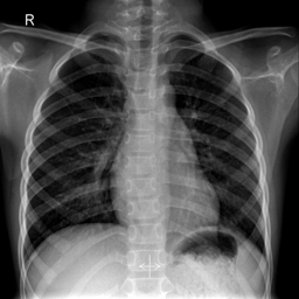

In [ ]:
normal = list(data_dir.glob('Normal/*'))  
print(normal[0])
print(len(normal))
PIL.Image.open(str(normal[0]))


/content/extracted_data/COVID/COVID-210.png
1001


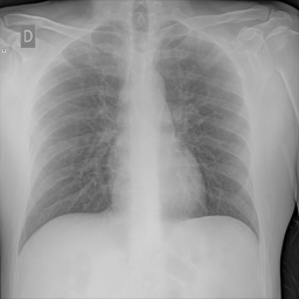

In [ ]:
covid = list(data_dir.glob('COVID/*'))
print(covid[0])
print(len(covid))
PIL.Image.open(str(covid[0]))

# split this two folders into Train-testing groups by using kernel command

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  #color_mode = "grayscale", #black-white
  image_size=IMAGE_SHAPE,
  batch_size=32,
  label_mode = "int")



Found 2201 files belonging to 2 classes.
Using 1761 files for training.


In [ ]:
example = train_ds.take(1)
print(example)
print(train_ds)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  #color_mode = "grayscale", #black-white
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=32,
  label_mode = "int")

Found 2201 files belonging to 2 classes.
Using 440 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Normal']


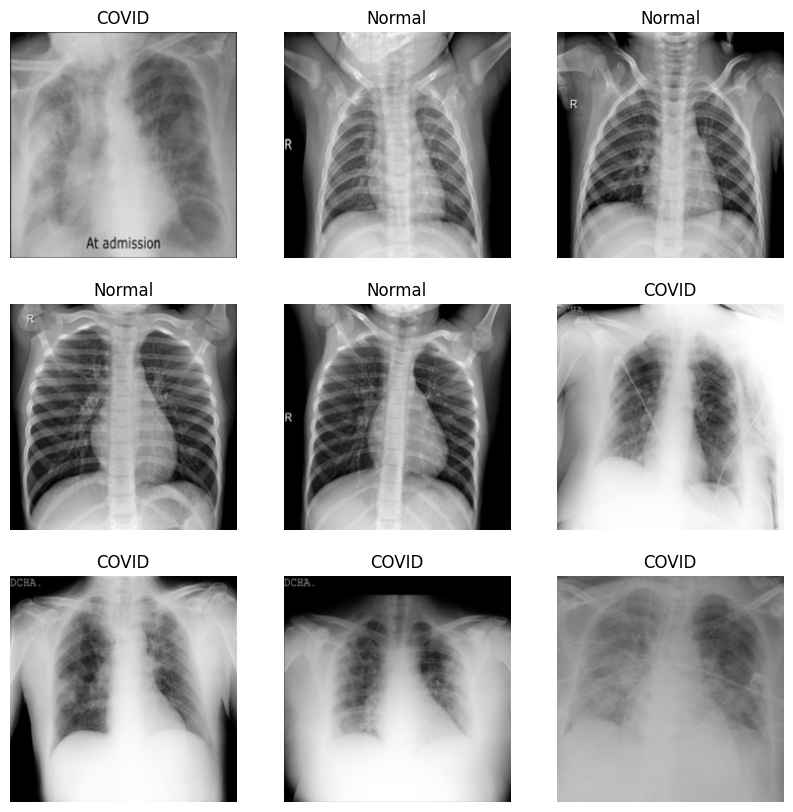

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap = "gray" )
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# Set our model

In [ ]:
tf.keras.backend.clear_session()

r_model = keras.Sequential()

pretrained_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
for layer in pretrained_model.layers:
  layer.trainable = False

#  Adding pretrained model as a layer

In [ ]:
r_model.add(pretrained_model)

# Add other layers

In [ ]:

r_model.add(tf.keras.layers.Input(shape=(224, 224, 3)))
#r_model.add(pretrained_model)
r_model.add(keras.layers.Flatten())
r_model.add(keras.layers.Dense(1024, activation='relu'))
r_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
r_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25686913 (97.99 MB)
Trainable params: 2099201 (8.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile and train model

In [ ]:
r_model.compile(
    optimizer = optimizer,
    loss='binary_crossentropy',
     metrics=['accuracy']
                )

In [ ]:
epoch = 20

h = r_model.fit(
    train_ds,
    validation_data= val_ds,
    epochs = epoch,
    batch_size = 32,
)


Epoch 1/20
56/56 [==============================] - 14s 160ms/step - loss: 0.2853 - accuracy: 0.9341 - val_loss: 0.0991 - val_accuracy: 0.9705
Epoch 2/20
56/56 [==============================] - 9s 157ms/step - loss: 0.0515 - accuracy: 0.9807 - val_loss: 0.0897 - val_accuracy: 0.9705
Epoch 3/20
56/56 [==============================] - 9s 144ms/step - loss: 0.0441 - accuracy: 0.9824 - val_loss: 0.1047 - val_accuracy: 0.9705
Epoch 4/20
56/56 [==============================] - 9s 152ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0985 - val_accuracy: 0.9705
Epoch 5/20
56/56 [==============================] - 9s 157ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.1311 - val_accuracy: 0.9636
Epoch 6/20
56/56 [==============================] - 9s 154ms/step - loss: 0.0192 - accuracy: 0.9932 - val_loss: 0.0887 - val_accuracy: 0.9750
Epoch 7/20
56/56 [==============================] - 9s 141ms/step - loss: 0.0174 - accuracy: 0.9920 - val_loss: 0.0940 - val_accuracy: 0.9727
Epoch

In [ ]:
score = r_model.evaluate(train_ds, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0003628604463301599
Test accuracy: 1.0


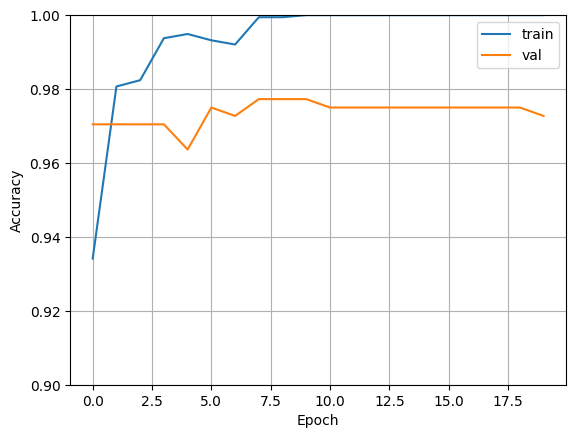

In [ ]:
fig_a = plt.gcf()
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.axis(ymin = 0.9,ymax = 1)
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['train','val'])
plt.show()

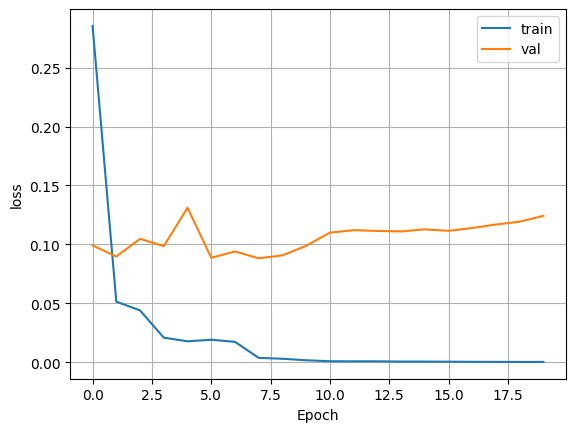

In [ ]:

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.grid()
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','val'])
plt.show()

In [ ]:
import cv2

image_1 = cv2.imread("/content/photo/COVID-1.png")
image_2 = cv2.imread("/content/photo/COVID-2.png")
image_3 = cv2.imread("/content/photo/COVID-3.png")
image_4 = cv2.imread("/content/photo/Normal-1.png")
image_5 = cv2.imread("/content/photo/Normal-2.png")
image_6 = cv2.imread("/content/photo/Normal-3.png")

images = [image_1,image_2,image_3,image_4,image_5,image_6]

In [ ]:
for i in range(len(images)):
    image_resized = cv2.resize(images[i], (224, 224))
    images[i] = np.expand_dims(image_resized, axis=0)
    print(images[i].shape)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [ ]:
prediction = r_model.predict(images[4])


1/1 [==============================] - 0s 206ms/step


In [ ]:
binary_predictions = np.round(prediction)
print("Binary Predictions:")
print(binary_predictions)

if binary_predictions == 0:
  print('Program say that there are COVID in X-Ray')
else:
  print('Program say that it is a Normal people in X-Ray')

Binary Predictions:
[[1.]]
Program say that it is a Normal people in X-Ray


In [ ]:
import os
import cv2
folder_path = "/content/testing data"

# List all files in the folder
files = os.listdir(folder_path)
image_files = [f for f in files if f.lower().endswith((".png", ".jpg", ".jpeg", ".gif"))]
for images in image_files:

    image = cv2.imread(os.path.join(folder_path, images))
    image_resized = cv2.resize(image, (224, 224))
    image_resized = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    prediction = r_model.predict(image_resized)
    ig, axes = plt.subplots(1, 2, figsize=(10, 5))
    img_path = f"/content/testing data/{images}"
    img = plt.imread(img_path)
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(images)

    scores = [prediction[0][0], (1 - prediction[0][0])]
    labels = ['Normal','Covid']
    axes[1].pie(scores, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Scores for {images}')

    plt.show()